In [1]:
import sys, os
os.environ['WANDB_NOTEBOOK_NAME'] = 'rbig_v2'
sys.path.append("/home/emmanuel/code/destructive-deep-learning")
# sys.path.append("/home/emmanuel/notebooks/jaxflows/scripts")

from data import get_toy_data
from visualize import plot_joint
from ddl.univariate import HistogramUnivariateDensity
from ddl.independent import (
    IndependentInverseCdf,
    IndependentDensity,
    IndependentDestructor,
)
from ddl.linear import LinearProjector
from ddl.base import CompositeDestructor
from ddl.deep import DeepDestructor, DeepDestructorCV
from sklearn.decomposition import PCA
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
# config parameters
n_samples = 10_000
dataset = "classic"
bins = "auto"  # bin estimation (uses automatric method)
bounds = 0.1  # percentage extension of the support
alpha = 1e-10  # regularization parameter for hist


### Data

In [10]:
def get_toy_data(n_samples=1000, seed=123):
    rng = np.random.RandomState(seed=seed)

    x = np.abs(2 * rng.randn(n_samples, 1))
    y = np.sin(x) + 0.25 * rng.randn(n_samples, 1)
    data = np.hstack((x, y))

    return data


## Plots

In [7]:
def plot_joint(
    data: np.ndarray, color: str = "red", title: str = "", kind="kde", logger=None
):

    plt.figure()
    sns.jointplot(x=data[:, 0], y=data[:, 1], kind=kind, color=color)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

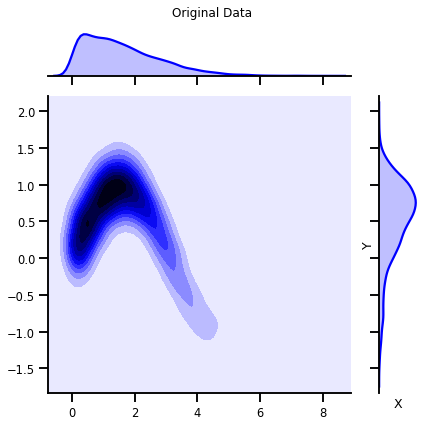

In [11]:
data = get_toy_data(n_samples=n_samples)


plot_joint(data, "blue", "Original Data")

## Deep Destructor

This is where we put everything in one block and add multiple layers.

In [12]:
%%time
from ddl.deep import DeepDestructorIT
# ==================================
# Step I - Marginal Uniformization
# ==================================
# Choose the Histogram estimator that converts the data X to uniform U(0,1)
univariate_estimator = HistogramUnivariateDensity(
    bounds=0.1, bins=1_000, alpha=1e-5
)

# Marginally uses histogram estimator
marginal_uniformization = IndependentDensity(
    univariate_estimators=univariate_estimator
)

# Creates "Destructor" D_theta_1
uniform_density = IndependentDestructor(marginal_uniformization)

# ===================================
# Step II - Marginal Gaussianization
# ===================================

# Choose destructor D_theta_2 that converts data
marginal_gaussianization = IndependentInverseCdf()

# ======================================
# Step III - Rotation
# ======================================

# Choose a linear projection to rotate the features (PCA) "D_theta_3"
rotation = LinearProjector(linear_estimator=PCA(svd_solver='randomized', random_state=123))

# ======================================
# All Steps - Deep Density Destructor
# ======================================
# rbig_block = CompositeDestructor(
#     destructors=
# )
rbig_flow = DeepDestructorIT(
    canonical_destructor=[uniform_density, marginal_gaussianization, rotation],
    base_dist="gaussian", 
    tol_layers=15,
    threshhold=0.25
)



CPU times: user 99 µs, sys: 0 ns, total: 99 µs
Wall time: 107 µs


In [13]:
from ddl.rbig import get_rbig_model

In [31]:
bins = 'auto'
bounds = 0.1
alpha = 1e-10
random_state = 123
tol_layers = 15
threshhold = 0.25
rotation = "pca"

rbig_flow = get_rbig_model(
    bins=bins, 
    bounds=bounds, 
    alpha=alpha, 
    random_state=random_state,
    rotation=rotation,
    tol_layers=tol_layers, 
    threshhold=threshhold
)

In [32]:
%%time

data = get_toy_data(n_samples=10_000, seed=123)
# Fit and transform data G_z ----> R (G_z)
G_approx = rbig_flow.fit_transform(data)

CPU times: user 10.8 s, sys: 1.82 s, total: 12.6 s
Wall time: 838 ms


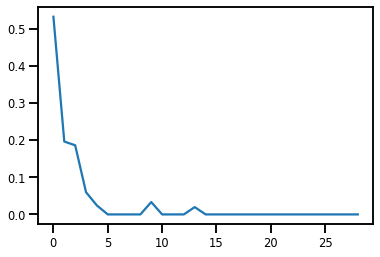

In [33]:
plt.plot(rbig_flow.info_loss)

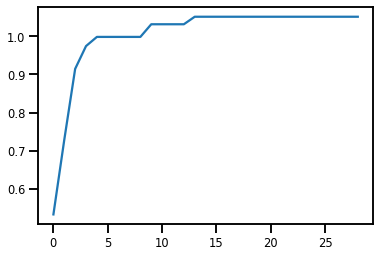

In [34]:
plt.plot(np.cumsum(rbig_flow.info_loss))

<Figure size 432x288 with 0 Axes>

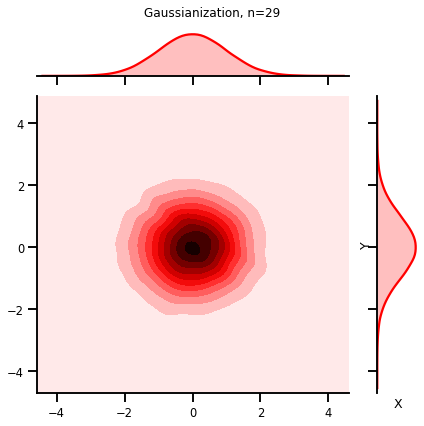

In [35]:
# Data Together
plot_joint(G_approx, "red", title=f"Gaussianization, n={rbig_flow.n_layers}")

### Inverse Transformation

In [36]:
# inverse transformation
data_approx = rbig_flow.inverse_transform(G_approx) 

In [37]:
# check that the inverse is almost equal
np.testing.assert_array_almost_equal(data_approx, data)

# calculate the residuals
residuals = np.sum((data_approx - data)**2)
print(f"Residuals: {residuals:.2e}")

Residuals: 1.10e-24


<Figure size 432x288 with 0 Axes>

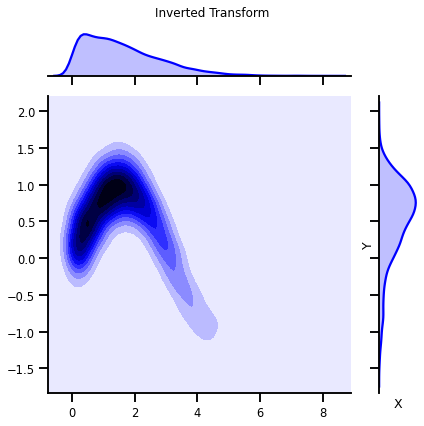

In [38]:
plot_joint(data_approx, "blue", title=f"Inverted Transform")

### Sampling

Now that we have a sufficient amount of layers, we can also sample from our base distribution and produce samples in our data distribution.

In [39]:
%%time

# Data Together
data_approx = rbig_flow.sample(10_000, random_state=123)

CPU times: user 230 ms, sys: 0 ns, total: 230 ms
Wall time: 229 ms


<Figure size 432x288 with 0 Axes>

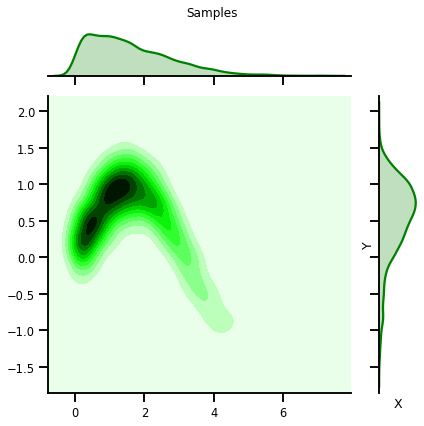

In [40]:
plot_joint(data_approx, "green", title=f"Samples")

## Probabilities

In [41]:
X_log_prob = rbig_flow.score_samples(data)

In [42]:
def plot_joint_prob(
    data: np.ndarray, probs: np.ndarray, cmap="Reds", title="", logger=None
):

    fig, ax = plt.subplots()
    h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs, cmap=cmap)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(h,)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

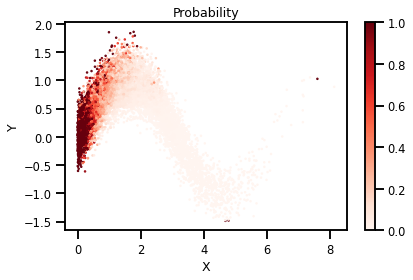

In [43]:
# convert to probability
X_prob = np.exp(X_log_prob)

# clip some extreme values
X_prob = np.clip(X_prob, 0.0, 1.0)

# plot
plot_joint_prob(data, X_prob, title="Probability")

### Negative Log-Likelihood

In [29]:
nll = rbig_flow.score(data)
print(f"Negative Log-Likelihood Score: {nll:.4f}")

Negative Log-Likelihood Score: -2.6506


### Total Correlation

In [30]:
total_corr = rbig_flow.total_corr(base=2)
print(f"Total Correlation: {total_corr:.4f}")

Total Correlation: 0.7272
